In [17]:
food_cat = ["Vegetables","Meats","Substitute Foods","Snack Foods","Dairy Products","Chilled Foods","Frozen Foods","Fruits","Beverages","Spices / Seasonings",
"Canned / Jarred Foods","Dried Sea Foods","Sea Foods","Grains","Coffee / Tea","Cooked Foods","Health Foods","Liquors / Alcoholic Beverages"]

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno
sns.set_style("darkgrid")

import matplotlib as mpl

mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["font.size"] = 10

import plotly.graph_objects as go
import plotly.express as px

import pickle
import os
import gc

In [19]:
def resumetable(df):
    print(f"DataSet Shape : {df.shape}")
    summary = pd.DataFrame(df.dtypes, columns={'dtypes'})
    summary = summary.reset_index()
    summary["Name"] = summary["index"]
    summary = summary[["Name","dtypes"]]
    summary['Missing'] = df.isnull().sum().values
    summary['Unique'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values
    
    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, "Entropy"] = round(stats.entropy(df[name].value_counts(normalize = True), base=2),2)
        
    return summary

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

from IPython.core.display import HTML

def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )

In [5]:
os.chdir("./제6회 L.POINT Big Data Competition/")

In [6]:
online_df = pd.read_csv("clear_merged_online_df.csv")
online_df = reduce_mem_usage(online_df)

Mem. usage decreased to 399.14 Mb (46.7% reduction)


In [7]:
#전체기간 소분류별 총 판매량

food_df = online_df[online_df.clac_nm1.isin(food_cat)].reset_index()
food_sales = pd.get_dummies(food_df[["clac_nm3"]],).sum().reset_index(name = "sales").rename(columns={"index" : "clac_nm3"})
food_sales.loc[:,"clac_nm3"] = sorted(food_df.clac_nm3.dropna().unique().tolist())

totsales_clac_nm3 = food_sales

In [14]:
cat3_to_cat1 = online_df[["clac_nm1","clac_nm3"]].dropna().drop_duplicates(["clac_nm1","clac_nm3"], keep ="first").set_index("clac_nm3").to_dict().get("clac_nm1")

In [15]:
cat2_to_cat1 = online_df[["clac_nm1","clac_nm2"]].dropna().drop_duplicates(["clac_nm1","clac_nm2"], keep ="first").set_index("clac_nm2").to_dict().get("clac_nm1")

In [57]:
totsales_clac_nm3["clac_nm1"] = totsales_clac_nm3.clac_nm3.map(cat3_to_cat1)

In [49]:
#전체기간 중분류별 총 판매량

food_df = online_df[online_df.clac_nm1.isin(food_cat)].reset_index()
food_sales = pd.get_dummies(food_df[["clac_nm2"]],).sum().reset_index(name = "sales").rename(columns={"index" : "clac_nm2"})
food_sales.loc[:,"clac_nm2"] = sorted(food_df.clac_nm2.dropna().unique().tolist())

totsales_clac_nm2 = food_sales

In [51]:
#2. 음식 카테고리 구매한 사람들의 쇼핑 패턴(순차패턴분석/ 각 행동유형 별 비중/ 접속 시간대/ 구매 시간대 / 머문 시간)

필요한 분석 list  

* 거시적인 변화
    1. 시간에 따른 음식 전체 구매율 변화(3달치)
    2. 시간에 따른 음식 전체 접속율 변화(3달치) #음식카테고리 구매 사람들 한하여 접속률 변화 

* 거시적 접속율 파악
    1. 음식 카테고리 요일별 접속율
    2. 음식 카테고리 시간별 접속율 
    3. 음식 카테고리 전체 접속기기 분포
    4. 음식 카테고리 시간별 접속기기 분포
    5. 음식 카테고리 요일별 접속기기 분포 

* 거시적 구매율 파악
    1. 음식 카테고리 요일별 구매율
    2. 음식 카테고리 시간별 구매율 

* 각 카테고리별 탐색
    1. 음식 카테고리 안에서 각 중/소분류별 구매율
    2. 음식 카테고리 안에서 각 중/소분류별 접속율

##  시간에 따른 음식카테고리 전체 구매율 변화

In [20]:
#시간별 총 session_id 갯수
unique_sess_id_per_hour = online_df.drop_duplicates(["clnt_id","sess_id","month","day","hour"], keep = "first").groupby("hour").size().reset_index().rename(columns = {0 : 'tot_counts'})

In [140]:
unique_sess_id_per_hour = online_df.drop_duplicates(["clnt_id","sess_id","month","day","hour"], keep = "first").groupby(["hour","dvc_ctg_nm"]).size().reset_index().rename(columns = {0 : 'tot_counts'})

In [151]:
unique_sess_id_per_hour = unique_sess_id_per_hour.sort_values(by = ["dvc_ctg_nm","hour"], ascending = [1,1]).reset_index(drop = True)

### 요일별 구매율 & 시간별 구매율 ( 전체 & 음식 )

In [135]:
# 요일별 구매율

In [21]:
hour_sale = online_df[online_df.action_type==6].drop_duplicates(["sess_id","clnt_id"], keep = "first").groupby(["hour"]).size().reset_index(name = "tot_sales")
hour_sess = online_df.drop_duplicates(["clnt_id","sess_id"] , keep = "first").groupby(["hour"]).size().reset_index(name = "tot_sess")
hour_sale = hour_sale.merge(hour_sess)
hour_sale["purc_rate"] = np.round(hour_sale.tot_sales / hour_sale.tot_sess, 4) * 100

In [22]:
weekday_sale = online_df[online_df.action_type==6].drop_duplicates(["sess_id","clnt_id"], keep = "first").groupby(["weekday"]).size().reset_index(name = "tot_sales")
weekday_sess = online_df.drop_duplicates(["clnt_id","sess_id"] , keep = "first").groupby(["weekday"]).size().reset_index(name = "tot_sess")
weekday_sale = weekday_sale.merge(weekday_sess)
weekday_sale["purc_rate"] = np.round(weekday_sale.tot_sales / weekday_sale.tot_sess,4) * 100

In [23]:
# hour_sale

Text(0.5, 1.0, '요일별 구매율')

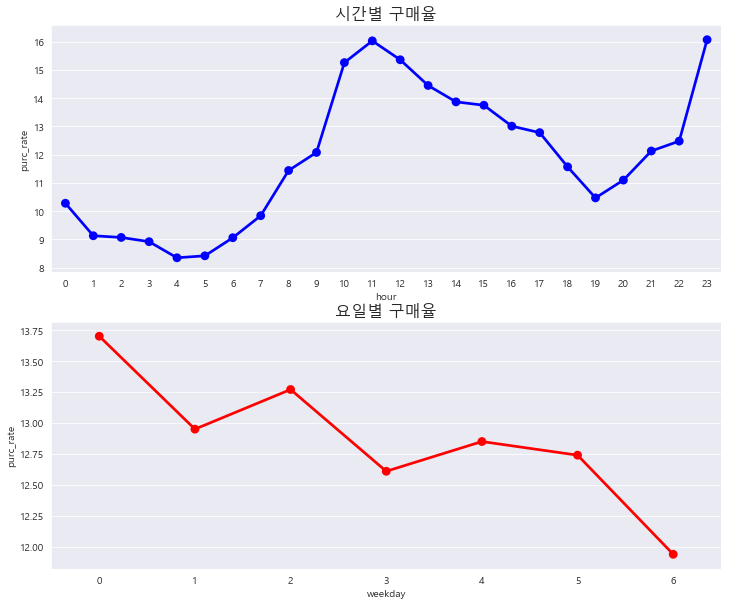

In [24]:
fig,ax = plt.subplots(nrows=2 , figsize = (12,10))
sns.pointplot(x = hour_sale.hour, y=hour_sale.purc_rate, ax = ax[0], color = "blue")
sns.pointplot(x = weekday_sale.weekday, y=weekday_sale.purc_rate, ax = ax[1], color = "red")
ax[0].set_title("시간별 구매율", fontsize = 16)
ax[1].set_title("요일별 구매율", fontsize = 16)

In [25]:
#음식

In [28]:
hour_sale_food = food_df[food_df.action_type==6].drop_duplicates(["sess_id","clnt_id"], keep = "first").groupby(["hour"]).size().reset_index(name = "tot_sales")
hour_sess = online_df.drop_duplicates(["clnt_id","sess_id"] , keep = "first").groupby(["hour"]).size().reset_index(name = "tot_sess")
hour_sale_food = hour_sale_food.merge(hour_sess)
hour_sale_food["purc_rate"] = np.round(hour_sale_food.tot_sales / hour_sale_food.tot_sess, 4) * 100

weekday_sale_food = food_df[food_df.action_type==6].drop_duplicates(["sess_id","clnt_id"], keep = "first").groupby(["weekday"]).size().reset_index(name = "tot_sales")
weekday_sess = online_df.drop_duplicates(["clnt_id","sess_id"] , keep = "first").groupby(["weekday"]).size().reset_index(name = "tot_sess")
weekday_sale_food = weekday_sale_food.merge(weekday_sess)
weekday_sale_food["purc_rate"] = np.round(weekday_sale_food.tot_sales / weekday_sale_food.tot_sess,4) * 100

In [193]:
hour_sale_food = food_df.groupby(["hour"]).size().reset_index(name = "food_sales")
hour_tot_sales = online_df[online_df.action_type==6].groupby(["hour"]).size().reset_index(name = "tot_sales")
hour_sale_food = hour_sale_food.merge(hour_tot_sales)
hour_sale_food["purc_rate"] = np.round(hour_sale_food.food_sales / hour_sale_food.tot_sales, 4) * 100

In [ ]:
fig,ax = plt.subplots(nrows=2 , figsize = (12,10))
sns.pointplot(x = hour_sale_food.hour, y=hour_sale_food.purc_rate, ax = ax[0], color = "blue")
sns.pointplot(x = weekday_sale_food.weekday, y=weekday_sale_food.purc_rate, ax = ax[1], color = "red")
ax[0].set_title("시간별 구매율 - 음식", fontsize = 16)
ax[1].set_title("요일별 구매율 - 음식", fontsize = 16)

In [34]:
hour_sale_food = food_df.groupby(["hour"]).size().reset_index(name = "food_sales")
hour_tot_sales = online_df[online_df.action_type==6].groupby(["hour"]).size().reset_index(name = "tot_sales")
hour_sale_food = hour_sale_food.merge(hour_tot_sales)
hour_sale_food["purc_rate"] = np.round(hour_sale_food.food_sales / hour_sale_food.tot_sales, 4) * 100

In [35]:
weekday_sale_food = food_df.groupby(["weekday"]).size().reset_index(name = "food_sales")
weekday_tot_sales = online_df[online_df.action_type==6].groupby(["weekday"]).size().reset_index(name = "tot_sales")
weekday_sale_food = weekday_sale_food.merge(weekday_tot_sales)
weekday_sale_food["purc_rate"] = np.round(weekday_sale_food.food_sales / weekday_sale_food.tot_sales, 4) * 100

(0, 80)

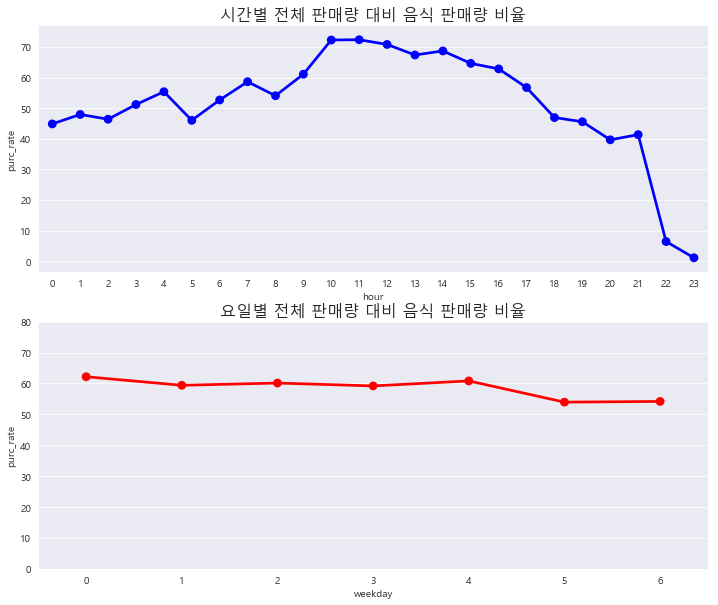

In [39]:
fig,ax = plt.subplots(nrows=2 , figsize = (12,10))
sns.pointplot(x = hour_sale_food.hour, y=hour_sale_food.purc_rate, ax = ax[0], color = "blue")
sns.pointplot(x = weekday_sale_food.weekday, y=weekday_sale_food.purc_rate, ax = ax[1], color = "red")
ax[0].set_title("시간별 전체 판매량 대비 음식 판매량 비율", fontsize = 16)
ax[1].set_title("요일별 전체 판매량 대비 음식 판매량 비율", fontsize = 16)
ax[1].set_ylim(0,80)

index                  0
clnt_id                0
sess_id                0
hit_seq                0
action_type            0
biz_unit               0
sess_dt                0
hit_tm                 0
hit_pss_tm             0
trans_id               0
sech_kwd           76585
tot_pag_view_ct        0
tot_sess_hr_v          0
trfc_src               0
dvc_ctg_nm             0
time                   0
year                   0
month                  0
day                    0
weekday                0
hour                   0
min                    0
trans_seq              0
pd_c                   0
buy_am                 0
buy_ct                 0
clnt_gender            0
clnt_age               0
clac_nm1               0
clac_nm2               0
clac_nm3               5
dtype: int64

### +접속기기 

In [152]:
sub_mobile_web = food_df[food_df.dvc_ctg_nm == "mobile_web"]
sub_mobile_app = food_df[food_df.dvc_ctg_nm == "mobile_app"]
sub_PC = food_df[food_df.dvc_ctg_nm == "PC"]
sub_unknown = food_df[food_df.dvc_ctg_nm == "unknown"]

In [153]:
#시간대별 구매이력이 있는 session_id수
unique_purchase_id_per_hour_mobile_web = sub_mobile_web[sub_mobile_web.action_type==6].groupby(["clnt_id","sess_id",'hour']).size().reset_index().groupby(["hour"]).size().reset_index(name = "purc_counts")

#시간대별 구매이력이 있는 session_id수
unique_purchase_id_per_hour_mobile_app = sub_mobile_app[sub_mobile_app.action_type==6].groupby(["clnt_id","sess_id",'hour']).size().reset_index().groupby(["hour"]).size().reset_index(name = "purc_counts")

#시간대별 구매이력이 있는 session_id수
unique_purchase_id_per_hour_PC = sub_PC[sub_PC.action_type==6].groupby(["clnt_id","sess_id",'hour']).size().reset_index().groupby(["hour"]).size().reset_index(name = "purc_counts")

#시간대별 구매이력이 있는 session_id수
unique_purchase_id_per_hour_unknown = sub_unknown[sub_unknown.action_type==6].groupby(["clnt_id","sess_id",'hour']).size().reset_index().groupby(["hour"]).size().reset_index(name = "purc_counts")

In [154]:
purchase_rate_mobile_web = unique_sess_id_per_hour[unique_sess_id_per_hour.dvc_ctg_nm == "mobile_web"].merge(unique_purchase_id_per_hour_mobile_web)
purchase_rate_mobile_web["purc_rate"] = np.round(purchase_rate_mobile_web.purc_counts / purchase_rate_mobile_web.tot_counts * 100,2)

purchase_rate_mobile_app = unique_sess_id_per_hour[unique_sess_id_per_hour.dvc_ctg_nm == "mobile_app"].merge(unique_purchase_id_per_hour_mobile_app)
purchase_rate_mobile_app["purc_rate"] = np.round(purchase_rate_mobile_app.purc_counts / purchase_rate_mobile_app.tot_counts * 100,2)

purchase_rate_PC = unique_sess_id_per_hour[unique_sess_id_per_hour.dvc_ctg_nm == "PC"].merge(unique_purchase_id_per_hour_PC)
purchase_rate_PC["purc_rate"] = np.round(purchase_rate_PC.purc_counts / purchase_rate_PC.tot_counts * 100,2)

purchase_rate_unknown = unique_sess_id_per_hour[unique_sess_id_per_hour.dvc_ctg_nm == "unknown"].merge(unique_purchase_id_per_hour_unknown)
purchase_rate_unknown["purc_rate"] = np.round(purchase_rate_unknown.purc_counts / purchase_rate_unknown.tot_counts * 100,2)

purchase_rate_mobile_web["device"] = "mobile_web"
purchase_rate_mobile_app["device"] = "mobile_app"
purchase_rate_PC["device"] = "PC"
purchase_rate_unknown["device"] = "unknown"

In [155]:
purchase_rate_by_dvc = pd.concat([purchase_rate_mobile_web, purchase_rate_mobile_app, purchase_rate_PC, purchase_rate_unknown]).reset_index(drop = True)

In [1]:
"""plt.figure(figsize = (16,6))
sns.pointplot(x = "hour", y = "purc_rate", hue = "device", data = purchase_rate_by_dvc)
plt.title("접속기기 + 시간별 음식카테고리 구매율", fontsize = 20)"""

'plt.figure(figsize = (16,6))\nsns.pointplot(x = "hour", y = "purc_rate", hue = "device", data = purchase_rate_by_dvc)\nplt.title("접속기기 + 시간별 음식카테고리 구매율", fontsize = 20)'

#### 접속기기 + 요일

In [111]:
#시간별 총 session_id 갯수
unique_sess_id_per_hour = online_df.drop_duplicates(["clnt_id","sess_id","month","day","hour"], keep = "first").groupby(["weekday","hour"]).size().reset_index(name = "tot_counts")

In [283]:
unique_sess_id_per_hour = online_df.drop_duplicates(["clnt_id","sess_id","dvc_ctg_nm"], keep = "first").groupby(["dvc_ctg_nm","weekday","hour"]).size().reset_index(name = "tot_counts")

In [284]:
#시간대별 구매이력이 있는 session_id수
unique_purchase_id_per_hour_mobile_web = sub_mobile_web[sub_mobile_web.action_type==6].groupby(["clnt_id","sess_id","weekday","hour"]).size().reset_index().groupby(["weekday","hour"]).size().reset_index(name = "purc_counts")

#시간대별 구매이력이 있는 session_id수
unique_purchase_id_per_hour_mobile_app = sub_mobile_app[sub_mobile_app.action_type==6].groupby(["clnt_id","sess_id","weekday","hour"]).size().reset_index().groupby(["weekday","hour"]).size().reset_index(name = "purc_counts")

#시간대별 구매이력이 있는 session_id수
unique_purchase_id_per_hour_PC = sub_PC[sub_PC.action_type==6].groupby(["clnt_id","sess_id","weekday","hour"]).size().reset_index().groupby(["weekday","hour"]).size().reset_index(name = "purc_counts")

#시간대별 구매이력이 있는 session_id수
unique_purchase_id_per_hour_unknown = sub_unknown[sub_unknown.action_type==6].groupby(["clnt_id","sess_id","weekday","hour"]).size().reset_index().groupby(["weekday","hour"]).size().reset_index(name = "purc_counts")

In [285]:
purchase_rate_mobile_web = unique_sess_id_per_hour[unique_sess_id_per_hour.dvc_ctg_nm == "mobile_web"].merge(unique_purchase_id_per_hour_mobile_web, on = ["weekday","hour"])
purchase_rate_mobile_web["purc_rate"] = np.round(purchase_rate_mobile_web.purc_counts / purchase_rate_mobile_web.tot_counts * 100,2)

purchase_rate_mobile_app = unique_sess_id_per_hour[unique_sess_id_per_hour.dvc_ctg_nm == "mobile_app"].merge(unique_purchase_id_per_hour_mobile_app, on = ["weekday","hour"])
purchase_rate_mobile_app["purc_rate"] = np.round(purchase_rate_mobile_app.purc_counts / purchase_rate_mobile_app.tot_counts * 100,2)

purchase_rate_PC = unique_sess_id_per_hour[unique_sess_id_per_hour.dvc_ctg_nm == "PC"].merge(unique_purchase_id_per_hour_PC, on = ["weekday","hour"])
purchase_rate_PC["purc_rate"] = np.round(purchase_rate_PC.purc_counts / purchase_rate_PC.tot_counts * 100,2)

purchase_rate_unknown = unique_sess_id_per_hour[unique_sess_id_per_hour.dvc_ctg_nm == "unknown"].merge(unique_purchase_id_per_hour_unknown, on = ["weekday","hour"])
purchase_rate_unknown["purc_rate"] = np.round(purchase_rate_unknown.purc_counts / purchase_rate_unknown.tot_counts * 100,2)

purchase_rate_mobile_web["device"] = "mobile_web"
purchase_rate_mobile_app["device"] = "mobile_app"
purchase_rate_PC["device"] = "PC"
purchase_rate_unknown["device"] = "unknown"

In [279]:
"""purchase_rate_mobile_web = unique_sess_id_per_hour.merge(unique_purchase_id_per_hour_mobile_web)
purchase_rate_mobile_web["purc_rate"] = np.round(purchase_rate_mobile_web.purc_counts / purchase_rate_mobile_web.tot_counts * 100,2)

purchase_rate_mobile_app = unique_sess_id_per_hour.merge(unique_purchase_id_per_hour_mobile_app)
purchase_rate_mobile_app["purc_rate"] = np.round(purchase_rate_mobile_app.purc_counts / purchase_rate_mobile_app.tot_counts * 100,2)

purchase_rate_PC = unique_sess_id_per_hour.merge(unique_purchase_id_per_hour_PC)
purchase_rate_PC["purc_rate"] = np.round(purchase_rate_PC.purc_counts / purchase_rate_PC.tot_counts * 100,2)

purchase_rate_unknown = unique_sess_id_per_hour.merge(unique_purchase_id_per_hour_unknown)
purchase_rate_unknown["purc_rate"] = np.round(purchase_rate_unknown.purc_counts / purchase_rate_unknown.tot_counts * 100,2)

purchase_rate_mobile_web["device"] = "mobile_web"
purchase_rate_mobile_app["device"] = "mobile_app"
purchase_rate_PC["device"] = "PC"
purchase_rate_unknown["device"] = "unknown" """

'purchase_rate_mobile_web = unique_sess_id_per_hour.merge(unique_purchase_id_per_hour_mobile_web)\npurchase_rate_mobile_web["purc_rate"] = np.round(purchase_rate_mobile_web.purc_counts / purchase_rate_mobile_web.tot_counts * 100,2)\n\npurchase_rate_mobile_app = unique_sess_id_per_hour.merge(unique_purchase_id_per_hour_mobile_app)\npurchase_rate_mobile_app["purc_rate"] = np.round(purchase_rate_mobile_app.purc_counts / purchase_rate_mobile_app.tot_counts * 100,2)\n\npurchase_rate_PC = unique_sess_id_per_hour.merge(unique_purchase_id_per_hour_PC)\npurchase_rate_PC["purc_rate"] = np.round(purchase_rate_PC.purc_counts / purchase_rate_PC.tot_counts * 100,2)\n\npurchase_rate_unknown = unique_sess_id_per_hour.merge(unique_purchase_id_per_hour_unknown)\npurchase_rate_unknown["purc_rate"] = np.round(purchase_rate_unknown.purc_counts / purchase_rate_unknown.tot_counts * 100,2)\n\npurchase_rate_mobile_web["device"] = "mobile_web"\npurchase_rate_mobile_app["device"] = "mobile_app"\npurchase_rate_PC

In [286]:
purchase_rate_by_dvc = pd.concat([purchase_rate_mobile_web, purchase_rate_mobile_app, purchase_rate_PC, purchase_rate_unknown]).reset_index(drop = True)

In [120]:
weekdays = ["월","화","수","목","금","토","일"]

In [ ]:
sns.distplot()

In [2]:
"""for day in range(7):
    tmp_df = purchase_rate_by_dvc[purchase_rate_by_dvc.weekday == day]
    fig, ax = plt.subplots(figsize =  (10,5))
    sns.lineplot(x = tmp_df.hour, y = tmp_df.purc_rate, hue = tmp_df.device, ax = ax, linewidth = 1)
    ax.set_title(weekdays[day])
    plt.show()
    # fig.savefig("./plots/기기+시간_{}요일_구매율".format(weekdays[day]))"""

'for day in range(7):\n    tmp_df = purchase_rate_by_dvc[purchase_rate_by_dvc.weekday == day]\n    fig, ax = plt.subplots(figsize =  (10,5))\n    sns.lineplot(x = tmp_df.hour, y = tmp_df.purc_rate, hue = tmp_df.device, ax = ax, linewidth = 1)\n    ax.set_title(weekdays[day])\n    plt.show()\n    # fig.savefig("./plots/기기+시간_{}요일_구매율".format(weekdays[day]))'

In [ ]:
plt.figure(figsize = (16,6))
sns.pointplot(x = "hour", y = "purc_rate", hue = "device", data = purchase_rate_by_dvc)
plt.title("접속기기 + 시간별 음식카테고리 구매율", fontsize = 20)

In [63]:
#####

### +접속경로

In [107]:
#시간대별 총 session_id수
unique_sess_id_per_hour_by_trfc_src = online_df.drop_duplicates(["clnt_id","sess_id","trfc_src","month","day","hour"], keep = "first").\
groupby(["trfc_src", "hour"]).size().reset_index().rename(columns = {0 : 'tot_counts'})

unique_sess_id_per_hour_by_trfc_src = unique_sess_id_per_hour_by_trfc_src.sort_values(["trfc_src", "hour"], ascending = [1,1])

unique_purchase_id_per_hour_by_trfc_src = food_df[food_df.action_type==6].drop_duplicates(["clnt_id","sess_id"], keep = "first").groupby(["clnt_id","sess_id","hour","trfc_src"]).size().reset_index().groupby(["trfc_src","hour"]).size().reset_index(name = "purc_counts").sort_values(by = ["trfc_src","hour"], ascending = [1,1])

purchase_rate_by_trfc_src = unique_sess_id_per_hour_by_trfc_src.merge(unique_purchase_id_per_hour_by_trfc_src, how = "left", on = ["trfc_src","hour"]).fillna(0)

purchase_rate_by_trfc_src["purc_rate"] = np.round(purchase_rate_by_trfc_src.purc_counts / purchase_rate_by_trfc_src.tot_counts * 100,2)

Text(0.5, 1.0, '접속경로 및 시간별 음식 카테고리 구매율')

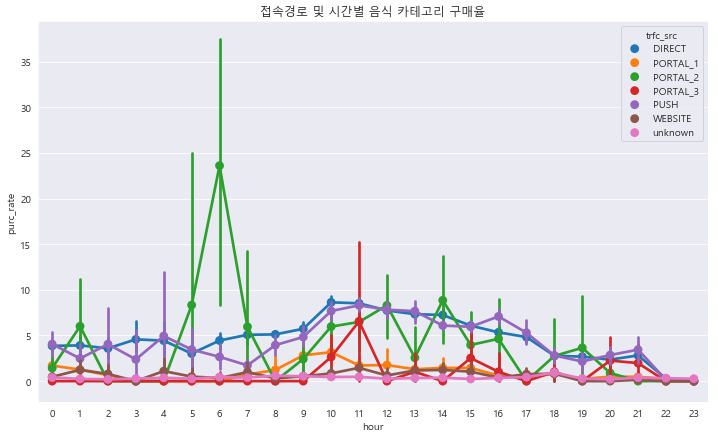

In [275]:
plt.figure(figsize = (12,7))
sns.pointplot(data = purchase_rate_by_trfc_src, x="hour", y="purc_rate", hue="trfc_src")
plt.title("접속경로 및 시간별 음식 카테고리 구매율")

#### 접속경로 + 요일 

In [163]:
#시간대별 총 session_id수
unique_sess_id_per_hour_by_trfc_src = online_df.drop_duplicates(["clnt_id","sess_id","trfc_src","month","day","hour"], keep = "first").\
groupby(["trfc_src","weekday", "hour"]).size().reset_index().rename(columns = {0 : 'tot_counts'})

In [292]:
unique_purchase_id_per_hour_by_trfc_src

,trfc_src,weekday,hour,purc_counts
0,DIRECT,0,0,14
23,DIRECT,1,0,25
46,DIRECT,2,0,23
69,DIRECT,3,0,21
92,DIRECT,4,0,25
115,DIRECT,5,0,17
134,DIRECT,6,0,18
1,DIRECT,0,1,13
24,DIRECT,1,1,6
47,DIRECT,2,1,9


In [166]:
unique_sess_id_per_hour_by_trfc_src = unique_sess_id_per_hour_by_trfc_src.sort_values(["trfc_src","weekday","hour"], ascending = [1,1,1])

unique_purchase_id_per_hour_by_trfc_src = food_df[food_df.action_type==6].drop_duplicates(["clnt_id","sess_id"], keep = "first").groupby(["clnt_id","sess_id","weekday", "hour","trfc_src"]).size().reset_index().groupby(["trfc_src","weekday","hour"]).size().reset_index(name = "purc_counts").sort_values(by = ["trfc_src","hour"], ascending = [1,1])

purchase_rate_by_trfc_src = unique_sess_id_per_hour_by_trfc_src.merge(unique_purchase_id_per_hour_by_trfc_src, how = "left", on = ["trfc_src","weekday","hour"]).fillna(0)

purchase_rate_by_trfc_src["purc_rate"] = np.round(purchase_rate_by_trfc_src.purc_counts / purchase_rate_by_trfc_src.tot_counts * 100,2)

In [173]:
purchase_rate_by_trfc_src.columns

Index(['trfc_src', 'weekday', 'hour', 'tot_counts', 'purc_counts',
       'purc_rate'],
      dtype='object')

In [ ]:
sns.lineplot()

In [3]:
"""g = sns.FacetGrid(data = purchase_rate_by_trfc_src, col="weekday", row="trfc_src")
g.map(sns.lineplot, "hour", "purc_rate", color = 'k')"""

'g = sns.FacetGrid(data = purchase_rate_by_trfc_src, col="weekday", row="trfc_src")\ng.map(sns.lineplot, "hour", "purc_rate", color = \'k\')'

In [4]:
"""for day in range(7):
    tmp_df = purchase_rate_by_trfc_src[purchase_rate_by_trfc_src.weekday == day]
    fig, ax = plt.subplots(figsize =  (10,5))
    sns.lineplot(x = tmp_df.hour, y = tmp_df.purc_rate, hue = tmp_df.trfc_src, ax = ax)
    ax.set_title(weekdays[day])
    plt.show()
    #fig.savefig("./plots/기기+시간_{}요일_구매율".format(weekdays[day]))"""

'for day in range(7):\n    tmp_df = purchase_rate_by_trfc_src[purchase_rate_by_trfc_src.weekday == day]\n    fig, ax = plt.subplots(figsize =  (10,5))\n    sns.lineplot(x = tmp_df.hour, y = tmp_df.purc_rate, hue = tmp_df.trfc_src, ax = ax)\n    ax.set_title(weekdays[day])\n    plt.show()\n    #fig.savefig("./plots/기기+시간_{}요일_구매율".format(weekdays[day]))'

## 시간에 따른 음식 전체 구매율 변화(3달치)

### 음식카테고리 판매량 추이 

In [182]:
purc_df = pd.concat([food_df[~food_df.clac_nm3.isnull()][["clnt_id","time","month","day","hour","weekday"]],
           pd.get_dummies(food_df.clac_nm3.dropna())], axis=1).reset_index(drop = True)

In [231]:
food_sales_by_day = pd.DataFrame({"time" : pd.date_range(start="20190701", end="20190930"),
             "food_sales" : purc_df.groupby(["month",'day']).sum().drop(["clnt_id","hour","weekday"], axis=1).reset_index().iloc[:,2:].sum(axis=1).values})

In [5]:
"""food_sales_by_day.set_index("time").resample("M").mean().plot(figsize = (16,6), title = "음식카테고리 판매량 추이(월별)")
food_sales_by_day.set_index("time").resample("7D").mean().plot(figsize = (16,6), title = "음식카테고리 판매량 추이(주별)")
food_sales_by_day.set_index("time").plot(figsize = (16,6), title = "음식카테고리 판매량 추이(일별)")"""

'food_sales_by_day.set_index("time").resample("M").mean().plot(figsize = (16,6), title = "음식카테고리 판매량 추이(월별)")\nfood_sales_by_day.set_index("time").resample("7D").mean().plot(figsize = (16,6), title = "음식카테고리 판매량 추이(주별)")\nfood_sales_by_day.set_index("time").plot(figsize = (16,6), title = "음식카테고리 판매량 추이(일별)")'

### 일별 총 세션수 

In [184]:
purc_df = pd.concat([food_df[~food_df.clac_nm3.isnull()][["clnt_id","sess_id","time","month","day","hour","weekday"]],
           pd.get_dummies(food_df.clac_nm3.dropna())], axis=1).reset_index(drop = True)

In [254]:
purc_df.head() # 음식카테고리 중 적어도 하나 이상을 산 세션

,clnt_id,sess_id,time,month,day,hour,weekday,Aekjeot,Almonds,Apples,...,Webfoot Octopus,Wild Honey,Winter-grown Cabbages,Wrapping Vegetables,Yellow Corvina Fish,Yellow Corvina Fish Gift Sets,Yogurt Drinks,Young Pumpkins,Young Radishes,kelp
0,2,8,2019-07-31 21:25:00,7,31,21,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,8,2019-07-31 21:25:00,7,31,21,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,8,2019-07-31 21:25:00,7,31,21,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,8,2019-07-31 21:25:00,7,31,21,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,8,2019-07-31 21:25:00,7,31,21,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [259]:
tot_purc_session_by_day = purc_df.groupby(["clnt_id","sess_id","month","day"]).size().reset_index().groupby(["month",'day']).size().reset_index(name = "tot_purc_sess_count")

In [260]:
purc_rate_by_day = pd.concat([tot_purc_session_by_day[["tot_purc_sess_count"]], tot_sess_count_by_day[["tot_sess_count"]]], axis=1)

In [262]:
purc_rate_by_day["purc_rate"] = np.round(purc_rate_by_day.tot_purc_sess_count / purc_rate_by_day.tot_sess_count, 4) * 100

In [267]:
purc_rate_by_day.set_index(pd.date_range(start="20190701", end = "20190930"), inplace=True)

In [6]:
"""# 전체세션갯수 ( 구매하지 않은 세션포함 )
# 음식을 구매한 세션의 수 
purc_rate_by_day.drop(["tot_purc_sess_count","tot_sess_count"], axis=1).plot(figsize = (16,6), title = "음식카테고리 구매율 추이")"""

'# 전체세션갯수 ( 구매하지 않은 세션포함 )\n# 음식을 구매한 세션의 수 \npurc_rate_by_day.drop(["tot_purc_sess_count","tot_sess_count"], axis=1).plot(figsize = (16,6), title = "음식카테고리 구매율 추이")'

In [7]:
"""purc_rate_by_day.drop(["tot_purc_sess_count","tot_sess_count"], axis=1).resample("M").mean().plot(figsize = (16,6), title = "음식카테고리 구매율 추이(월별)")
purc_rate_by_day.drop(["tot_purc_sess_count","tot_sess_count"], axis=1).resample("7D").mean().plot(figsize = (16,6), title = "음식카테고리 구매율 추이(주별)")
purc_rate_by_day.drop(["tot_purc_sess_count","tot_sess_count"], axis=1).plot(figsize = (16,6), title = "음식카테고리 구매율 추이(일별)")"""

'purc_rate_by_day.drop(["tot_purc_sess_count","tot_sess_count"], axis=1).resample("M").mean().plot(figsize = (16,6), title = "음식카테고리 구매율 추이(월별)")\npurc_rate_by_day.drop(["tot_purc_sess_count","tot_sess_count"], axis=1).resample("7D").mean().plot(figsize = (16,6), title = "음식카테고리 구매율 추이(주별)")\npurc_rate_by_day.drop(["tot_purc_sess_count","tot_sess_count"], axis=1).plot(figsize = (16,6), title = "음식카테고리 구매율 추이(일별)")'

Text(0.5, 1.0, '평균세션접속시간 분포 비교 : 음식 / 비음식')

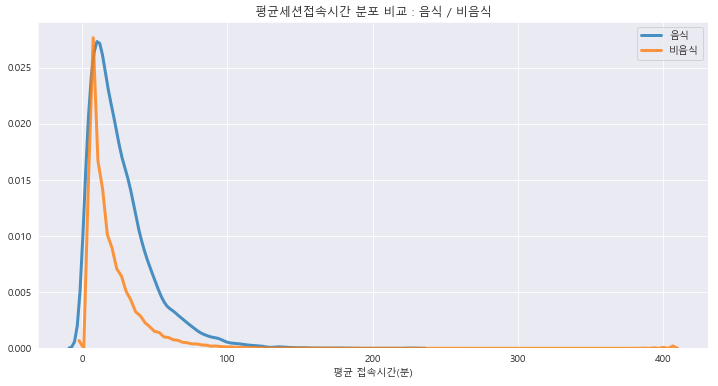

In [327]:
fig, ax = plt.subplots(figsize= (12,6))
sns.distplot(food_df.drop_duplicates(["clnt_id","sess_id"], keep ="first").tot_sess_hr_v//60, ax = ax , hist = False, label = "음식", kde_kws={"linewidth" : 3, "alpha": .8})
sns.distplot(online_df[~online_df.clac_nm1.isin(food_cat)].drop_duplicates(["clnt_id","sess_id"], keep ="first").tot_sess_hr_v//60, ax = ax, hist = False, label = "비음식", kde_kws={"linewidth" : 3, "alpha": .8})
# sns.distplot(online_df.drop_duplicates(["clnt_id","sess_id"], keep ="first").tot_sess_hr_v//60, ax = ax, hist = False, label = "total", kde_kws={"linewidth" : 3, "alpha": .6})
ax.set_xlabel("평균 접속시간(분)")
ax.set_title("평균세션접속시간 분포 비교 : 음식 / 비음식")

In [319]:
(food_df.drop_duplicates(["clnt_id","sess_id"], keep ="first").tot_sess_hr_v//60).quantile([.5, .75, .9, .95])

0.50    21.0
0.75    36.0
0.90    55.0
0.95    70.0
Name: tot_sess_hr_v, dtype: float64

In [321]:
(online_df[~online_df.clac_nm1.isin(food_cat)].drop_duplicates(["clnt_id","sess_id"], keep ="first").tot_sess_hr_v//60).quantile([.5, .75, .9, .95])

0.50     3.0
0.75    12.0
0.90    28.0
0.95    41.0
Name: tot_sess_hr_v, dtype: float64

In [320]:
(online_df[online_df.action_type==6].drop_duplicates(["clnt_id","sess_id"], keep ="first").tot_sess_hr_v//60).quantile([.5, .75, .9, .95])

0.50    16.0
0.75    31.0
0.90    50.0
0.95    65.0
Name: tot_sess_hr_v, dtype: float64

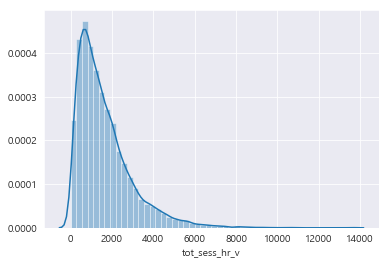

In [299]:
# 평균적으로 얼마동안 머물렀는지 
sns.distplot(food_df.drop_duplicates(["clnt_id","sess_id"], keep ="first").tot_sess_hr_v)

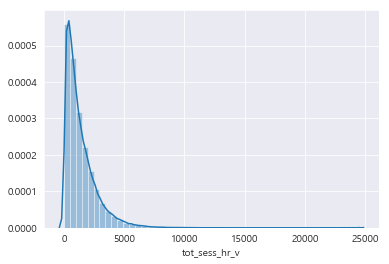

In [301]:
sns.distplot(online_df[online_df.action_type==6].drop_duplicates(["clnt_id","sess_id"], keep ="first").tot_sess_hr_v)

In [ ]:
# 어떤 유입채널이 제일 높은지 (순위)
# 어떤 접속기기가 제일 높은지 (순위)

In [333]:
food_df.drop_duplicates(["clnt_id","sess_id"], keep = "first").dvc_ctg_nm.value_counts().reset_index(name = "dvc_count")

,index,dvc_count
0,unknown,7889
1,mobile_web,1904
2,mobile_app,550
3,PC,487


Text(0.5, 0, '접속기기')

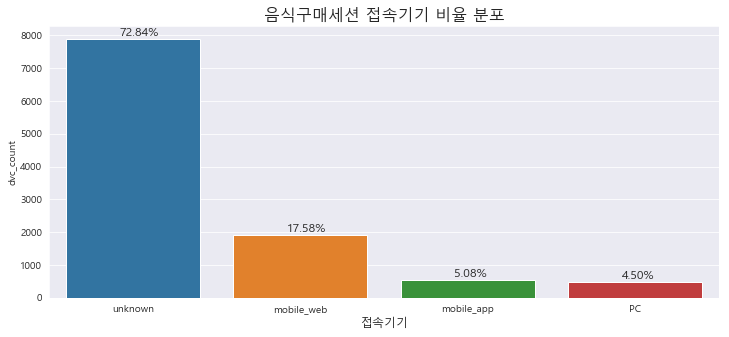

In [350]:
fig, ax = plt.subplots(figsize = (12,5))
sns.barplot(x="index", y="dvc_count", data = food_df.drop_duplicates(["clnt_id","sess_id"], keep = "first").dvc_ctg_nm.value_counts().reset_index(name = "dvc_count"), ax = ax)

total = food_df.drop_duplicates(["clnt_id","sess_id"], keep = "first").shape[0]

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.5, height + 100,
          "{0:.2f}%".format(height/total * 100), fontsize= 12)
    
ax.set_title("음식구매세션 접속기기 비율 분포", fontsize = 16)
ax.set_xlabel("접속기기", fontsize = 12)

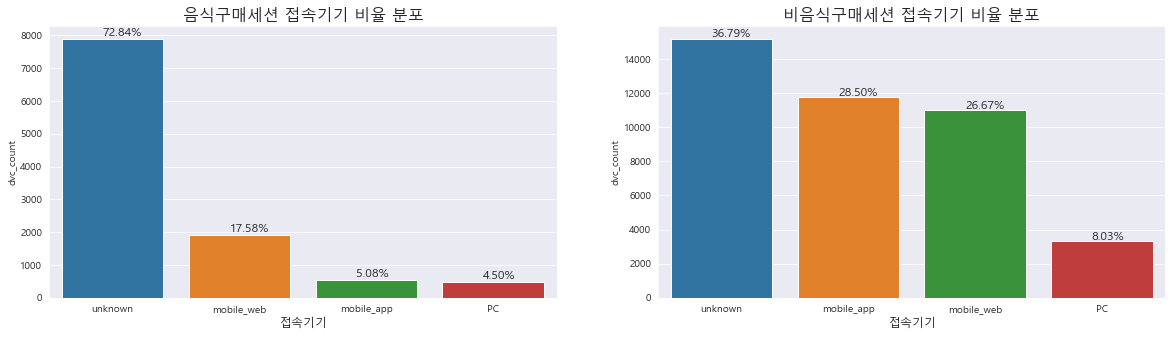

In [380]:
fig, ax = plt.subplots(ncols=2, figsize = (20,5))

sns.barplot(x="index", y="dvc_count", data = food_df.drop_duplicates(["clnt_id","sess_id"], keep = "first").dvc_ctg_nm.value_counts().reset_index(name = "dvc_count"), ax = ax[0])
sns.barplot(x="index", y="dvc_count", data = online_df[(~online_df.clac_nm1.isin(food_cat)) & (online_df.action_type == 6)].drop_duplicates(["clnt_id","sess_id"], keep = "first").dvc_ctg_nm.value_counts().reset_index(name = "dvc_count"), ax = ax[1])

total = food_df.drop_duplicates(["clnt_id","sess_id"], keep = "first").shape[0]
total1 = online_df[(~online_df.clac_nm1.isin(food_cat)) & (online_df.action_type == 6)].drop_duplicates(["clnt_id","sess_id"], keep = "first").shape[0]

for p in ax[0].patches:
    height = p.get_height()
    ax[0].text(p.get_x()+p.get_width()/2.5, height + 100,
          "{0:.2f}%".format(height/total * 100), fontsize= 12)

for p in ax[1].patches:
    height = p.get_height()
    ax[1].text(p.get_x()+p.get_width()/2.5, height + 100,
          "{0:.2f}%".format(height/total1 * 100), fontsize= 12)
"""    
g1 = ax[0].twinx()
g1 = sns.pointplot(tmp_df.device, tmp_df.dvc_rate, color = 'k')

g2 = ax[1].twinx()
g2 = sns.pointplot(tmp_df.device, tmp_df.dvc_rate, color = 'k')
"""
ax[0].set_title("음식구매세션 접속기기 비율 분포", fontsize = 16)
ax[0].set_xlabel("접속기기", fontsize = 12)

ax[1].set_title("비음식구매세션 접속기기 비율 분포", fontsize = 16)
ax[1].set_xlabel("접속기기", fontsize = 12)

# fig.savefig("./plots/음식_비음식_구매세션_접속기기비율비교2.png")

In [359]:
tmp_df = online_df[online_df.action_type==6].drop_duplicates(["clnt_id","sess_id"], keep = "first").dvc_ctg_nm.value_counts().reset_index(name = "dvc_count")
tmp_df.rename(columns={'index':"device"}, inplace=True)
tmp_df["dvc_rate"] = np.round(tmp_df.dvc_count/tmp_df.dvc_count.sum(),4)*100

In [377]:
tmp_df

,device,dvc_count,dvc_rate
0,unknown,19542,41.22
1,mobile_app,12155,25.64
2,mobile_web,12107,25.54
3,PC,3603,7.60


Text(0.5, 0, '접속기기')

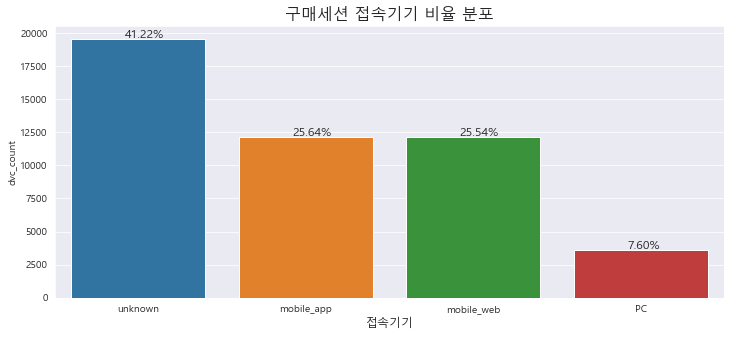

In [353]:
fig, ax = plt.subplots(figsize = (12,5))
sns.barplot(x="index", y="dvc_count", data = online_df[online_df.action_type==6].drop_duplicates(["clnt_id","sess_id"], keep = "first").dvc_ctg_nm.value_counts().reset_index(name = "dvc_count"), ax = ax)

total = online_df[online_df.action_type==6].drop_duplicates(["clnt_id","sess_id"], keep = "first").shape[0]

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.5, height + 100,
          "{0:.2f}%".format(height/total * 100), fontsize= 12)
    
ax.set_title("구매세션 접속기기 비율 분포", fontsize = 16)
ax.set_xlabel("접속기기", fontsize = 12)

In [ ]:
#접속경로

In [207]:
tmp_src = food_df.drop_duplicates(["clnt_id","sess_id"], keep = "first").trfc_src.value_counts().reset_index(name = "src_count")

In [105]:
tmp_src = pd.concat([tmp_src, pd.DataFrame({"index" : "PORTAL_ALL", "src_count" : 1}, index = [7])])
tmp_src.loc[tmp_src['index'] == "PORTAL_ALL", "src_count"] = tmp_src.iloc[4:7,1].sum()
tmp_src = tmp_src.iloc[[0,1,2,3,7],:].reset_index(drop = True)

In [77]:
tmp_df = online_df[online_df.action_type==6].drop_duplicates(["clnt_id","sess_id"], keep = "first").trfc_src.value_counts().reset_index(name = "src_count")
tmp_df.rename(columns={'index':"src"}, inplace=True)
tmp_df["dvc_rate"] = np.round(tmp_df.src_count/tmp_df.src_count.sum(),4)*100

In [126]:
tmp_src2 = online_df[(~online_df.clac_nm1.isin(food_cat)) & (online_df.action_type == 6)].drop_duplicates(["clnt_id","sess_id"], keep = "first").trfc_src.value_counts().reset_index(name = "src_count")

In [127]:
tmp_src2 = pd.concat([tmp_src2, pd.DataFrame({"index" : "PORTAL_ALL", "src_count" : 1}, index = [7])])
tmp_src2.loc[tmp_src2['index'] == "PORTAL_ALL", "src_count"] = tmp_src2.iloc[4:7,1].sum()
tmp_src2 = tmp_src2.iloc[[0,1,2,3,7],:].reset_index(drop = True)

Text(0.5, 0, '접속기기')

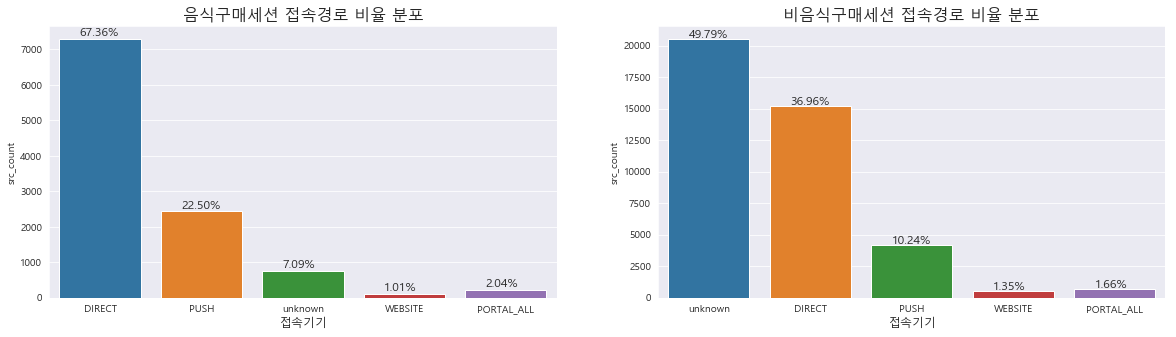

In [129]:
fig, ax = plt.subplots(ncols=2, figsize = (20,5))

#sns.barplot(x="index", y="src_count", data = food_df.drop_duplicates(["clnt_id","sess_id"], keep = "first").trfc_src.value_counts().reset_index(name = "src_count"), ax = ax[0])
sns.barplot(x="index", y="src_count", data = tmp_src, ax = ax[0])

sns.barplot(x="index", y="src_count", data = tmp_src2, ax = ax[1])

total = food_df.drop_duplicates(["clnt_id","sess_id"], keep = "first").shape[0]
total1 = online_df[(~online_df.clac_nm1.isin(food_cat)) & (online_df.action_type == 6)].drop_duplicates(["clnt_id","sess_id"], keep = "first").shape[0]

for p in ax[0].patches:
    height = p.get_height()
    ax[0].text(p.get_x()+p.get_width()/4, height + 75,
          "{0:.2f}%".format(height/total * 100), fontsize= 12)

for p in ax[1].patches:
    height = p.get_height()
    ax[1].text(p.get_x()+p.get_width()/4, height + 75,
          "{0:.2f}%".format(height/total1 * 100), fontsize= 12)
    
"""
g1 = ax[0].twinx()
g1 = sns.pointplot(tmp_df.src, tmp_df.dvc_rate, color = 'k')

g2 = ax[1].twinx()
g2 = sns.pointplot(tmp_df.src, tmp_df.dvc_rate, color = 'k')
"""
ax[0].set_title("음식구매세션 접속경로 비율 분포", fontsize = 16)
ax[0].set_xlabel("접속기기", fontsize = 12)

ax[1].set_title("비음식구매세션 접속경로 비율 분포", fontsize = 16)
ax[1].set_xlabel("접속경로", fontsize = 12)

# fig.savefig("./plots/음식_비음식_구매세션_접속기기비율비교2.png")

In [130]:
tmp_src

,index,src_count
0,DIRECT,7295
1,PUSH,2437
2,unknown,768
3,WEBSITE,109
4,PORTAL_ALL,221


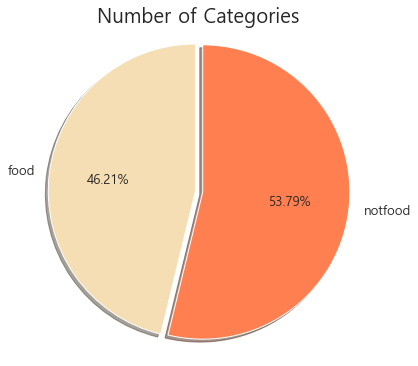

In [16]:
# group_colors = ["skyblue",'magenta', 'yellowgreen', "orange" ,"red"]
group_explodes = [0.05, 0]

plt.figure(figsize = (6,6))
plt.pie([469,1015-469], 
        explode=group_explodes, 
        labels=["food","notfood"], # lightslategray
        colors=['wheat','coral'], 
        autopct='%1.2f%%', # second decimal place
        shadow=True,
        startangle=90,
        textprops={'fontsize': 13}) # text font size
plt.axis('equal') #  equal length of X and Y axis
plt.title('Number of Categories', fontsize=20)

plt.show()


ValueError: 'explode' must be of length 'x'

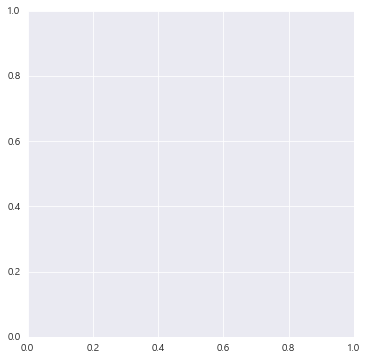

In [418]:
group_colors = ["skyblue",'magenta', 'yellowgreen', "orange" ,"red"]
group_explodes = [0.1, 0, 0, 0, 0]

plt.figure(figsize = (6,6))
plt.pie(tmp_src.src_count, 
        explode=group_explodes, 
        labels=tmp_src['index'], 
        colors=group_colors, 
        autopct='%1.2f%%', # second decimal place
        shadow=True,
        startangle=90,
        textprops={'fontsize': 12}) # text font size
plt.axis('equal') #  equal length of X and Y axis
plt.title('Category Numbers', fontsize=20)

plt.show()


In [ ]:
# 음식구매세션 action_type분포

In [8]:
tmp = pd.read_csv("buying_list_clac3.csv")

In [11]:
# tmp.iloc[:,1:-1].iloc[:,~tmp.columns.map(cat3_to_cat1).dropna().isin(food_cat)].sum(axis=1)[tmp.iloc[:,1:-1].iloc[:,~tmp.columns.map(cat3_to_cat1).dropna().isin(food_cat)].sum(axis=1) == 0].index

In [12]:
buying_list = tmp

In [9]:
import copy

In [16]:
tmp3 = copy.deepcopy(buying_list)
tmp3.columns = buying_list.columns[:].map(cat3_to_cat1)
tmp3.columns = np.where(tmp3.columns.isin(food_cat), "food","not_food")

In [322]:
tmp3.columns == "food"

In [18]:
tmp_3_sub1 = tmp3.iloc[:,tmp3.columns == "food"]
tmp_3_sub2 = tmp3.iloc[:,tmp3.columns != "food"]

In [19]:
tmp_3_sub1 = tmp_3_sub1.sum(axis=1).reset_index(name = "food_count")

In [20]:
tmp_3_sub2 = tmp_3_sub2.iloc[:,1:-1].sum(axis=1).reset_index(name = "not_food_count")

In [21]:
tmp4 = tmp_3_sub1.merge(tmp_3_sub2)

In [22]:
tmp4["tot_count_without_unknown"] = tmp4.food_count + tmp4.not_food_count

In [23]:
tmp4[tmp4.tot_count_without_unknown == 0].shape[0]

13415

In [24]:
np.where(tmp4[tmp4.tot_count_without_unknown != 0].not_food_count == 0, "food",
         np.where(tmp4[tmp4.tot_count_without_unknown != 0].food_count == 0, "not_food", "both"))

array(['food', 'both', 'not_food', ..., 'food', 'not_food', 'food'],
      dtype='<U8')

In [380]:
without_unknown = tmp4[tmp4.tot_count_without_unknown != 0]

In [383]:
without_unknown["pattern"] = np.where(tmp4[tmp4.tot_count_without_unknown != 0].not_food_count == 0, "food",
         np.where(tmp4[tmp4.tot_count_without_unknown != 0].food_count == 0, "not_food", "both"))

c:\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [388]:
without_unknown.pattern.value_counts()

not_food    2778
food        2763
both        1877
Name: pattern, dtype: int64

In [392]:
values = [2763, 2778, 1877, 13415]
groups = ["food", "not_food", "both", "unknown"]

In [439]:
group_colors = ['c', 'lightskyblue', 'lightgreen', "navajowhite"]
group_explodes = [0, 0, 0, 0.05]

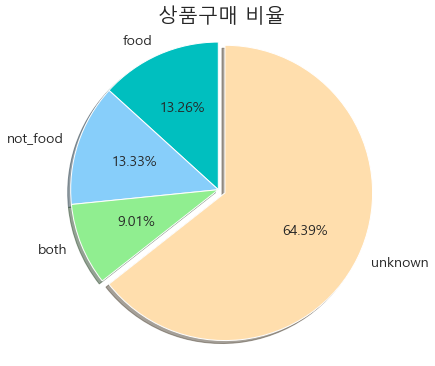

In [441]:
plt.figure(figsize = (6,6))
plt.pie(values, 
        explode=group_explodes, 
        labels=groups, 
        colors=group_colors, 
        autopct='%1.2f%%', # second decimal place
        shadow=True,
        startangle=90,
        textprops={'fontsize': 14}) # text font size
plt.axis('equal') #  equal length of X and Y axis
plt.title('상품구매 비율', fontsize=20)

plt.show()

In [12]:
only_food = tmp.iloc[tmp.iloc[:,1:-1].iloc[:,~tmp.columns.map(cat3_to_cat1).dropna().isin(food_cat)].sum(axis=1)[tmp.iloc[:,1:-1].iloc[:,~tmp.columns.map(cat3_to_cat1).dropna().isin(food_cat)].sum(axis=1) == 0].index,:]

In [413]:
only_food.shape[0] / tmp.shape[0]

0.7765564249027984

In [414]:
469 / 1015

0.46206896551724136

* 전체의 77.7%의 유저가 음식카테고리 외의 상품을 구매한적이 없음
* 음식카테고리는 전체 카테고리의 46.2%

In [ ]:
group_colors = ['magenta', 'yellowgreen']
group_explodes = [0.1, 0]

In [435]:
plt.figure(figsize = (6,6))
plt.pie(pd.DataFrame({"cat":["food","not_food"], "val" :[46.2,53.8]}).val, 
        explode=group_explodes, 
        labels=pd.DataFrame({"cat":["food","not_food"], "val" :[46.2,53.8]}).cat, 
        colors=group_colors, 
        autopct='%1.2f%%', # second decimal place
        shadow=True,
        startangle=90,
        textprops={'fontsize': 14}) # text font size
plt.axis('equal') #  equal length of X and Y axis
plt.title('Category Numbers', fontsize=20)

plt.show()

In [420]:
group_colors = ['lightskyblue', 'lightcoral']
group_explodes = [0.1, 0]

In [415]:
pd.DataFrame({"cat":["food","not_food"], "val" :[77.7,22.3]})

,cat,val
0,food,77.7
1,not_food,22.3


In [206]:
#tmp.iloc[:,1:-1].iloc[:,tmp.columns.map(cat3_to_cat1).dropna().isin(food_cat)]

## 음식 카테고리 안에서 각 중/소분류별 구매율

In [275]:
clac2_sales = purc_df.drop(["clnt_id","sess_id","time","month","day","hour","weekday"], axis=1).sum().reset_index(name = "tot_sales")

cat3_to_cat2 = online_df.drop_duplicates(["clac_nm3"], keep = "first").set_index("clac_nm3")[["clac_nm2"]].to_dict().get("clac_nm2")

clac2_sales["clac_2"] = clac2_sales['index'].map(cat3_to_cat2)

clac2_sales = clac2_sales.groupby("clac_2").sum()[["tot_sales"]].reset_index()

cat2_to_cat1 = online_df.drop_duplicates(["clac_nm2"], keep = "first")[["clac_nm2","clac_nm1"]].dropna().reset_index(drop = True).set_index("clac_nm2").to_dict().get("clac_nm1")
clac2_sales["clac_1"] = clac2_sales.clac_2.map(cat2_to_cat1)
clac2_sales["clac2_clac1"] = clac2_sales.clac_2 +"->"+clac2_sales.clac_1

In [277]:
clac2_sales["rate"] = np.round(clac2_sales.tot_sales / clac2_sales.tot_sales.sum(),4)*100

Text(0.5, 1.0, '음식카테고리 내 중분류 구매비율')

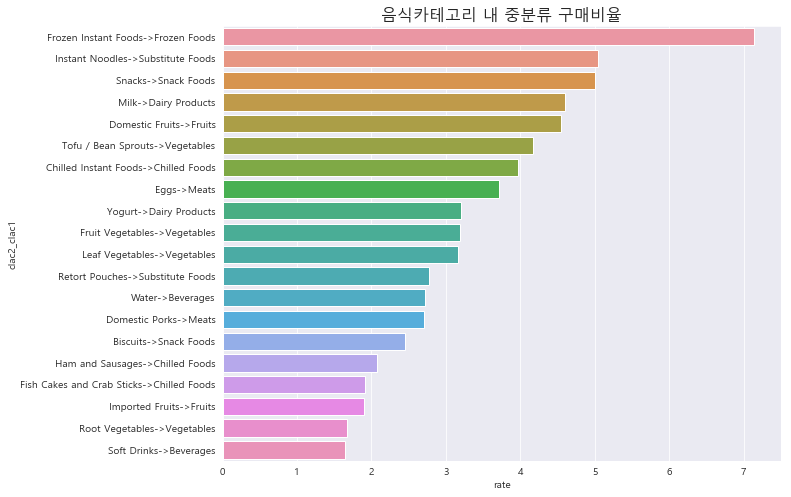

In [278]:
plt.figure(figsize = (10,8))
sns.barplot(y = "clac2_clac1", x="rate",data = clac2_sales.sort_values( by = "rate", ascending = False).head(20))
plt.title("음식카테고리 내 중분류 구매비율", fontsize = 16)

In [254]:
cat2_to_cat1 = online_df.drop_duplicates(["clac_nm2"], keep = "first")[["clac_nm2","clac_nm1"]].dropna().reset_index(drop = True).set_index("clac_nm2").to_dict().get("clac_nm1")
clac2_sales["clac_1"] = clac2_sales.clac_2.map(cat2_to_cat1)
clac2_sales["clac2_clac1"] = clac2_sales.clac_2 + clac2_sales.clac_1

### 음식만 구매한 사람들

In [58]:
only_food_user_info = only_food[["clnt_id"]].merge(pd.read_csv("제6회 L.POINT Big Data Competition-분석용데이터-03.고객 Demographic 정보.csv"), how = "left")

In [62]:
pd.crosstab(only_food_user_info.clnt_gender, only_food_user_info.clnt_age, normalize='index')

clnt_age,10,20,30,40,50,60,unknown
clnt_gender,,,,,,,
F,0.004006,0.081571,0.385096,0.388942,0.120353,0.020032,0.0
M,0.003984,0.094024,0.320319,0.410359,0.120319,0.050996,0.0
unknown,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0


,clnt_id,sess_id,clac_nm3
0,2,8,"[Coffee Drinks, Canned Vegetable Foods, Cream ..."
1,2,10,[Coffee Drinks]
2,2,19,[Ramens]
3,9,6,"[Frozen Dumplings, Pasta Noodles, Cookies, Fre..."
4,9,26,"[Functional Milk, Cheese, Fish Cakes, Frozen D..."
5,23,6,[Infant / Toddlers' Dresses]
6,24,5,"[Functional Milk, Frozen Hotdogs, Pasta Sauces..."
7,24,15,"[Rice, Chicken Eggs, Functional Milk, Frozen F..."
8,40,28,[Kids' Pillow / Pillow Cover]
9,40,33,[Women's Cardigans]


In [202]:
association_df = online_df[(online_df.action_type == 6) & (~online_df.clac_nm3.isnull())].groupby(["clnt_id","sess_id"]).agg({"clac_nm3" : "unique"}).reset_index()

In [204]:
association_df.to_csv("association.csv", index = False)

In [210]:
#음식구매세션 첫 action_type

In [222]:
action_types = food_df.groupby(["clnt_id","sess_id"]).size().reset_index()[["clnt_id","sess_id"]].merge(online_df, how = "left", on = ["clnt_id","sess_id"]).drop_duplicates(["clnt_id","sess_id"], keep = "first").action_type.value_counts()

In [226]:
action_types = action_types.reset_index(name = "action_counts").sort_values(by = "index")

In [228]:
action_types["action_rates"] = np.round(action_types.action_counts / action_types.action_counts.sum(),4) * 100

Text(0.5, 1.0, '음식구매세션 첫 action_type 비율')

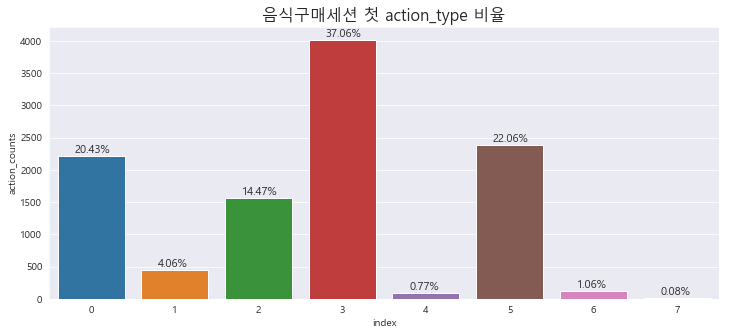

In [247]:
fig,ax = plt.subplots(figsize=(12,5))
sns.barplot(action_types['index'] , action_types.action_counts, ax = ax)

total = action_types.action_counts.sum()

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/4, height + 50,
           "{0:.2f}%".format((height/total)*100), fontsize = 11)
    
ax.set_title("음식구매세션 첫 action_type 비율", fontsize = 16)

비즈니스전략

In [7]:
# unknown제외 => 음식만 구매한 세션수, 비음식만 구매한 세션 수, 둘 다 구매한 세션 수

In [26]:
buy_sess_compare = online_df[online_df.action_type == 6].reset_index(drop = True)

In [30]:
np.where(buy_sess_compare.clac_nm1.isin(food_cat),"food","not_food")

array(['not_food', 'food', 'food', ..., 'food', 'food', 'not_food'],
      dtype='<U8')

In [31]:
buy_sess_compare["is_food"] = np.where(buy_sess_compare.clac_nm1.isin(food_cat),"food","not_food")

In [33]:
buy_sess_compare.loc[buy_sess_compare.clac_nm3.isnull(), "is_food"] = "unknown"

In [35]:
buy_sess_compare_without_unknown = buy_sess_compare[buy_sess_compare.is_food != "unknown"]

In [38]:
compare_df = buy_sess_compare_without_unknown.groupby(["clnt_id","sess_id"]).agg({"is_food" : "unique"}).reset_index()

In [50]:
compare_df['is_food'] = compare_df.is_food.apply(lambda x : list(x))

In [52]:
compare_df['n_uniq'] =  compare_df.is_food.apply(lambda x : len(x))

In [55]:
np.where(compare_df.loc[compare_df.n_uniq==1,:].is_food == ["food"], 1, 0)

ValueError: Lengths must match to compare

In [58]:
np.where(compare_df.loc[compare_df.n_uniq==1,:].is_food.apply(lambda x : x[0])=="food", "food", "not_food")

array([1, 1, 1, ..., 1, 0, 1])

In [61]:
compare_df.loc[compare_df.n_uniq==1,"food_sess"] = np.where(compare_df.loc[compare_df.n_uniq==1,:].is_food.apply(lambda x : x[0])=="food", "food", "not_food")

In [64]:
compare_df.fillna("both", inplace=True)

In [68]:
food_sess = compare_df.food_sess.value_counts().reset_index(name = "counts")

In [69]:
food_sess

,index,counts
0,food,8388
1,not_food,4893
2,both,2437


In [115]:
group_explodes = [0.06, 0, 0]
group_colors = ["springgreen", "beige", "lime"]

In [122]:
group_colors = ["Lightgray","Lightcoral","Mistyrose"]

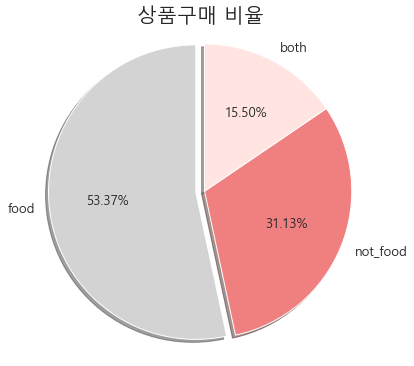

In [123]:
plt.figure(figsize = (6,6))
plt.pie(food_sess.counts, 
        explode=group_explodes, 
        labels=food_sess["index"], 
        colors=group_colors, 
        autopct='%1.2f%%', # second decimal place
        shadow=True,
        startangle=90,
        textprops={'fontsize': 13}) # text font size
plt.axis('equal') #  equal length of X and Y axis
plt.title('상품구매 비율', fontsize=20)

plt.show()